In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [13]:
%run lib2 --area_id=3 --bs=32 --num_workers=8 --num_slice=25 --gpu_start=0 --num_gpus=2
pad = True

In [3]:
from v17 import _internal_pred_to_poly_file, _calc_fscore_per_aoi

In [4]:
# valtest
test_csv = pd.read_csv(PATH/DATA_PATH/FMT_VALTEST_FN)
image_ids = test_csv['ImageId'].tolist()
test_y = load_y(image_ids, FMT_VALTEST_MASK_STORE)
x_names = [str(o) + '.png' for o in image_ids]

KeyboardInterrupt: 

In [14]:
# actual test
test_csv = pd.read_csv(PATH/DATA_PATH/FMT_TEST_FN)
image_ids = test_csv['ImageId'].tolist()
x_names = [str(o) + '.png' for o in image_ids]

In [15]:
test_csv.ImageId.tolist()

['AOI_3_Paris_img1325',
 'AOI_3_Paris_img255',
 'AOI_3_Paris_img498',
 'AOI_3_Paris_img257',
 'AOI_3_Paris_img556',
 'AOI_3_Paris_img145',
 'AOI_3_Paris_img1563',
 'AOI_3_Paris_img1708',
 'AOI_3_Paris_img1200',
 'AOI_3_Paris_img1580',
 'AOI_3_Paris_img1006',
 'AOI_3_Paris_img1634',
 'AOI_3_Paris_img732',
 'AOI_3_Paris_img2',
 'AOI_3_Paris_img1505',
 'AOI_3_Paris_img30',
 'AOI_3_Paris_img566',
 'AOI_3_Paris_img406',
 'AOI_3_Paris_img803',
 'AOI_3_Paris_img82',
 'AOI_3_Paris_img814',
 'AOI_3_Paris_img1612',
 'AOI_3_Paris_img1220',
 'AOI_3_Paris_img1545',
 'AOI_3_Paris_img635',
 'AOI_3_Paris_img1385',
 'AOI_3_Paris_img1046',
 'AOI_3_Paris_img1051',
 'AOI_3_Paris_img1358',
 'AOI_3_Paris_img1366',
 'AOI_3_Paris_img262',
 'AOI_3_Paris_img684',
 'AOI_3_Paris_img695',
 'AOI_3_Paris_img1453',
 'AOI_3_Paris_img1115',
 'AOI_3_Paris_img91',
 'AOI_3_Paris_img1862',
 'AOI_3_Paris_img237',
 'AOI_3_Paris_img1409',
 'AOI_3_Paris_img884',
 'AOI_3_Paris_img1361',
 'AOI_3_Paris_img1282',
 'AOI_3_Paris_img

In [5]:
stats = get_rgb_mean_stat(area_id)
aug_tfms = transforms_top_down
for o in aug_tfms: o.tfm_y = TfmType.CLASS
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)

In [6]:
model = get_model()

In [7]:
empty = ['empty'] * 2
trn = empty
val = empty
test = x_names
# datasets = ImageData.get_ds(OptionalFilesArrayDataset, trn, val, tfms,
#                             test=test, path=PATH/DATA_PATH/TRN, num_slice=num_slice, pad=pad)
datasets = ImageData.get_ds(OptionalFilesArrayDataset, trn, val, tfms,
                            test=test, path=PATH/DATA_PATH/TEST, num_slice=num_slice, pad=pad)
md = ImageData(str(PATH), datasets, bs, num_workers=num_workers, classes=None)
denorm = md.trn_ds.denorm

In [8]:
learn = get_learn(md, model, load_weight=True)

In [11]:
learn.model.eval()

DataParallel(
  (module): UNet16(
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3

In [44]:
def manual_predict(learn):
    n = learn.data.test_ds.get_n()
#     n = 25
    preds = np.empty((n, INPUT_SIZE, INPUT_SIZE))
    for o in tqdm.tqdm_notebook(range(0, n, bs)):
        end = min(n, o + bs)
        X, y = learn.data.test_dl.get_batch(range(o, end))
        preds[o:end] = sigmoid(learn.predict_array(X).squeeze())
    #preds = skimage.transform.resize(preds, (650, 650))
    return preds

In [23]:
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

In [45]:
preds_crop = manual_predict(learn)

In [33]:
%%time
preds_big = np.asarray(list(put_back_parallel(preds_crop, max_workers=4, padded=True))).squeeze()

CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 21.7 ms


In [ ]:
preds_big_sigmoid = to_np(F.sigmoid(T(preds_big)))

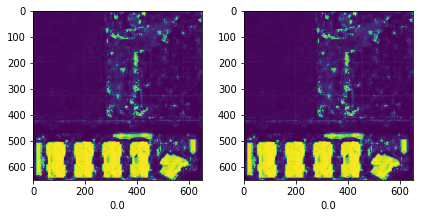

In [34]:
im_data = [[preds_big, preds_big]]
plot_ims(im_data)

In [9]:
preds = learn.predict(is_test=True).squeeze()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
%%time
preds_big = np.asarray(list(put_back_parallel(preds, max_workers=1, padded=False))).squeeze()

In [27]:
# %debug

In [ ]:
def find_thresh(preds_big):
    best_fscore, best_thresh = 0, 0
    records, fscores = [], []
    threshs = np.linspace(0.4, 0.9, 6)
    for thresh in threshs:
        _internal_pred_to_poly_file(
                area_id,
                preds_big,
                min_th=MIN_POLYGON_AREA,
                thresh=thresh,
                debug=False)
        evaluate_record = _calc_fscore_per_aoi(area_id)
        evaluate_record['min_area_th'] = MIN_POLYGON_AREA
        evaluate_record['area_id'] = area_id
        evaluate_record['thresh'] = thresh
        fscore = evaluate_record['fscore']
        records.append(evaluate_record)
        fscores.append(fscore)
        print(evaluate_record)
        if fscore > best_fscore:
            best_fscore = fscore
            best_record = evaluate_record
    return best_thresh, fscores, records

In [ ]:
best_thresh, fscores, records = find_thresh(preds_big_sigmoid)

In [ ]:
best_thresh = 0.7

In [ ]:
records, fscores = [], []
for th in range(30, 150, 30):
    _internal_pred_to_poly_file(area_id, preds_big_sigmoid, min_th=th, thresh=best_thresh, debug=False)
    evaluate_record = _calc_fscore_per_aoi(area_id)
    evaluate_record['min_area_th'] = th
    evaluate_record['area_id'] = area_id
    evaluate_record['thresh'] = best_thresh
    fscore = evaluate_record['fscore']
    records.append(evaluate_record)
    fscores.append(fscore)
    print(evaluate_record)
    
best_record = records[np.argmax(fscore)]
pd.DataFrame(best_record).to_csv(
    str(PATH/DATA_PATH/FMT_VALMODEL_EVALTHHIST),
    index=False)

# Submit

In [46]:
testproc(datapath, preds_crop, num_slice=num_slice)

In [ ]:
debug